In [330]:
# All Required libraries!!

import numpy as np
import pandas as pd

import mahotas as mh

from glob import glob

# visualization librairies
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

import os

import torch
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader


# set up GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Set the parameters that control the scaling of plot elements.
sns.set_context('notebook')
sns.set_style('white')

In [295]:
# # time to Load the Data (mahota time)

IMM_SIZE = 224

# Subfolders will be the names of possible diseases. (class_names variable)

def get_data(folder):
    class_names = [f for f in os.listdir(folder) if not f.startswith('.')] # create a list of SubFolders
    data = []
    print(class_names)
    for t, f in enumerate(class_names):
        images = glob(folder + "/" + f + "/*") # create a list of files
        print("Downloading: ", f)
        fig = plt.figure(figsize = (50,50)) 
        for im_n, im in enumerate(images):
            plt.gray() # set grey colormap of images
            image = mh.imread(im)
            if len(image.shape) > 2:
                image = mh.resize_to(image, [IMM_SIZE, IMM_SIZE, image.shape[2]]) # resize of RGB and png images
            else:
                image = mh.resize_to(image, [IMM_SIZE, IMM_SIZE]) # resize of grey images    
            if len(image.shape) > 2:
                image = mh.colors.rgb2grey(image[:,:,:3], dtype = np.uint8)  # change of colormap of images alpha chanel delete
            plt.subplot(int(len(images)/5)+1,5,im_n+1) # create a table of images
            plt.imshow(image)
            data.append([image, f])
        plt.show()

    return np.array(data)  

In [ ]:
d = "Covid19-dataset/train"
train = get_data(d)

d = "Covid19-dataset/test"
val = get_data(d)


print("Train shape", train.shape) # Size of the training DataSet
print("Test shape", val.shape) # Size of the test DataSet
print("Image size", train[0][0].shape) # Size of image

c:\Users\kon17\anaconda3\envs\virtual\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='count'>

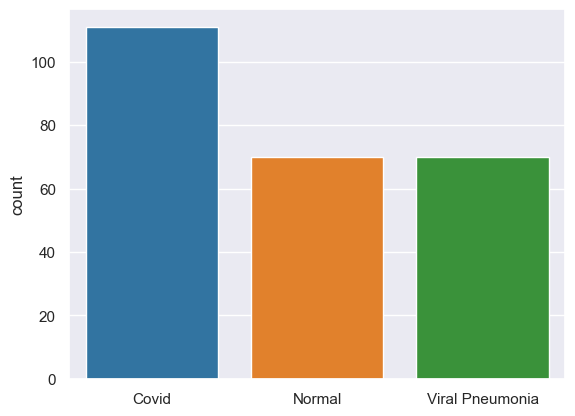

In [251]:
# Lets Visualize the data 

l = []
for i in train:
    l.append(i[1])
sns.set_style('darkgrid')
sns.countplot(l)

In [ ]:
# first image of covid

plt.figure(figsize = (5,5))
plt.imshow(train[np.where(train[:,1] == 'Covid')[0][0]][0])
plt.title('Covid')

In [252]:
                                                            # CREATION OF MODELS SECTION

In [253]:
                                                                    # CNN model

In [254]:
# Data preprocessing

x_train = []
y_train = []
x_val = []
y_val = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in val:
    x_val.append(feature)
    y_val.append(label)

# Normalize the data
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255


# Reshaping input images
x_train = x_train.reshape(-1, IMM_SIZE, IMM_SIZE, 1)
x_val = x_val.reshape(-1, IMM_SIZE, IMM_SIZE, 1)


# Creating a dictionary of clases
lab = {}
for i, l in enumerate(set(y_train)):
    lab[l] = i


y_train = np.array([lab[l] for l in y_train])
y_val = np.array([lab[l] for l in y_val])

In [255]:
print("Shape of the input DataSet:", x_train.shape)
print("Shape of the output DataSet:", y_train.shape) 
print("Dictionary of classes:", lab)

Shape of the input DataSet: (251, 224, 224, 1)
Shape of the output DataSet: (251,)
Dictionary of classes: {'Viral Pneumonia': 0, 'Normal': 1, 'Covid': 2}


In [ ]:
# Data augmentation

composed = transforms.Compose([transforms.RandomRotation(30), transforms.RandomHorizontalFlip(p=0.1), transforms.RandomVerticalFlip(p=0.1),                               
                               transforms.ToTensor()])    

x_train = composed(x_train)                                                                            

In [256]:
# create the CNN model
# 3 Convolutional layers followed by max-pooling layers. A dropout layer is added after the 3rd maxpool operation to avoid overfitting.

# CREATE THE MODEL
class CNN(nn.Module):
    
    # Contructor
    def __init__(self, out_1, out_2, out_3):
        super(CNN, self).__init__()
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=out_1, kernel_size=1)
        self.maxpool1=nn.MaxPool2d(kernel_size=1)

        self.cnn2 = nn.Conv2d(in_channels=out_1, out_channels=out_2, kernel_size=1)
        self.maxpool2=nn.MaxPool2d(kernel_size=1)
        
        self.cnn3 = nn.Conv2d(in_channels=out_2, out_channels=out_3, kernel_size=1)
        self.maxpool3=nn.MaxPool2d(kernel_size=1)
        self.dropout3 = nn.Dropout(p=0.4, inplace=True)
                
        self.fc1 = nn.Linear(128, 3)
    
    # Prediction
    def forward(self, x):
        x = self.cnn1(x)
        x = torch.relu(x)
        x = self.maxpool1(x)
        x = self.cnn2(x)
        x = torch.relu(x)
        x = self.maxpool2(x)
        x = self.cnn3(x)
        x = torch.relu(x)
        x = self.maxpool3(x)        
        x = self.dropout3(x)
        
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = torch.relu(x)
        x = torch.softmax(x)
        return x
    

model_CNN = CNN(32, 32, 64)
model_CNN.to(device)

CNN(
  (cnn1): Conv2d(1, 32, kernel_size=(1, 1), stride=(1, 1))
  (maxpool1): MaxPool2d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
  (cnn2): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
  (maxpool2): MaxPool2d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
  (cnn3): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1))
  (maxpool3): MaxPool2d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
  (dropout3): Dropout(p=0.4, inplace=True)
  (fc1): Linear(in_features=128, out_features=3, bias=True)
)

In [257]:
#                                                       U2NET MODEL EXPLANATION AND SEMANTICS 

# U2-Net : a two-level nested U-structure. Designed for saliency object detection or SOD (detecting the most important features in an image)

# Residual U-Block (RSU) mainly consists of three components:

# 1. An input convolution layer, which transforms the input feature map x (H×W ×C_in) to an intermediate map F1(x) with the channel of C_out. 

# 2. A U-Net-like symmetric encoder-decoder structure with a height of L 
#    that takes the intermediate feature map F1(x) as input and learns to extract and encode the multi-scale contextual information U(F1(x))

# 3. A residual connection that fuses local features and the multi-scale features by the summation: F1(x) +U(F1(x)).

In [258]:
def f(modules_dict, x):

    """
    This function takes in an OrderedDict (OrderedDict preserves the order in which the keys are inserted) that contains all the modules of a defined RSU block and an input x
    and returns a result of the forward passing of the modules
    
    """
    inner_enc_layers = []
    inner_dec_layers = []
    for layer_name, layer in modules_dict.items():
        if layer_name[-1] == 'd':
            inner_dec_layers.append(layer)
        else:
            inner_enc_layers.append(layer)

    hx = x
    hxin = inner_enc_layers[0](hx)
    hx = hxin
    inner_enc_outputs = []

    # inner block encode
    for layer in inner_enc_layers[1:]:
        hx = layer(hx)
        if not isinstance(layer, torch.nn.modules.pooling.MaxPool2d):
            inner_enc_outputs.append(hx)

    # inner block decode + residual function
    hxd = inner_dec_layers[0](torch.cat((inner_enc_outputs.pop(), inner_enc_outputs.pop()),1))
    for layer in inner_dec_layers[1:]:
        hxdup = _upsample_like(hxd, inner_enc_outputs[-1])
        hxd = layer(torch.cat((hxdup, inner_enc_outputs.pop()),1))

    return hxd + hxin

C:\Users\kon17\AppData\Local\Temp\ipykernel_18216\3872477726.py:2: MatplotlibDeprecationWarning: Directly reading images from URLs is deprecated since 3.4 and will no longer be supported two minor releases later. Please open the URL for reading and pass the result to Pillow, e.g. with ``np.array(PIL.Image.open(urllib.request.urlopen(url)))``.
  image = mpimg.imread(img_src)


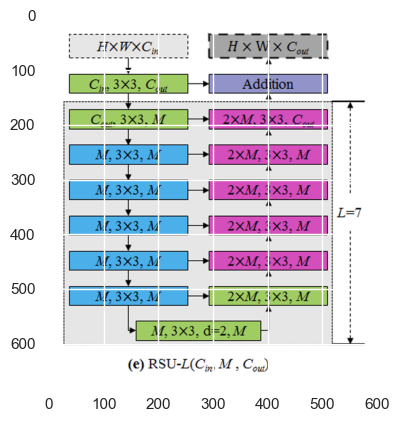

In [259]:
img_src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IND-GPXX0JV6EN/images/RSU.png"
image = mpimg.imread(img_src)   
imageplot = plt.imshow(image)
plt.show()


# The structure of RSU-L (C_in, M, C_out) . Here L is the number of layers in the encoder (or height), C_in, C_out denote input and output channels, 
# and M denotes the number of channels in the internal layers of RSU.                    

In [260]:
# Since an RSU consists of many Convolution + BatchNorm + Relu layers
# let's define a class that bundles the Convolution + BatchNorm + Relu activation together 

In [261]:
class REBNCONV(nn.Module):
    def __init__(self, in_ch=128, out_ch=3, dirate=1):
        super(REBNCONV, self).__init__()
        
        self.conv_s1 = nn.Conv2d(in_ch,out_ch,3,padding=1*dirate,dilation=1*dirate) 
        self.bn_s1 = nn.BatchNorm2d(out_ch)
        self.relu_s1 = nn.ReLU(inplace=True)

        
    def forward(self, x):
        hx = x
        return self.relu_s1(self.bn_s1(self.conv_s1(hx)))

In [262]:
# define function for upsamples (it upsamples `src` so that `src` has the same shape as `tar`) (source ---> to archive)

def _upsample_like(src, tar):
    
    src = F.upsample(src, size=tar.shape[2:], mode='bilinear')
    return src

In [263]:
# TIME TO BUILD 5 RSU-L BLOCKS (EACH CONTAINING L Convolution + BatchNorm + Relu layers)

In [264]:
# An RSU-7 block has depth (L) of 7. It consists of:

# One input `REBNCONV` layer;

# Seven downsampling `REBNCONV` layers, each followed by a `MaxPooling` layer except for `rebnconv6` and `rebnconv7` (to prevent the resolution of the last two layers being too low)

# Six upsampling `REBNCONV` layers, each takes the concatenation of the upsampled feature maps from its previous layer and those from its symmetrical upsamling layer as input.


class RSU7(nn.Module):

    def __init__(self, in_ch=128, mid_ch=12, out_ch=3):
        super(RSU7,self).__init__()

        self.rebnconvin = REBNCONV(in_ch,out_ch,dirate=1)

        self.rebnconv1 = REBNCONV(out_ch,mid_ch,dirate=1)
        self.pool1 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv2 = REBNCONV(mid_ch,mid_ch,dirate=1)
        self.pool2 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv3 = REBNCONV(mid_ch,mid_ch,dirate=1)
        self.pool3 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv4 = REBNCONV(mid_ch,mid_ch,dirate=1)
        self.pool4 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv5 = REBNCONV(mid_ch,mid_ch,dirate=1)
        self.pool5 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv6 = REBNCONV(mid_ch,mid_ch,dirate=1)

        self.rebnconv7 = REBNCONV(mid_ch,mid_ch,dirate=2)

        self.rebnconv6d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv5d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv4d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv3d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv2d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv1d = REBNCONV(mid_ch*2,out_ch,dirate=1)

        
    def forward(self,x):
        
        modules_dict = self.__dict__['_modules']
        result = f(modules_dict, x)
        return result

In [265]:
# An RSU-6 block has depth (L) of 6. It consists of:

# One input `REBNCONV` layer;

# Six downsampling `REBNCONV` layers, each followed by a `MaxPooling` layer except for `rebnconv5` and `rebnconv6` (to prevent the resolution of the last two layers being too low)

# Five upsampling `REBNCONV` layers, each takes the concatenation of the upsampled feature maps from its previous layer and those from its symmetrical upsamling layer as input.


class RSU6(nn.Module):

    def __init__(self, in_ch=128, mid_ch=12, out_ch=3):
        super(RSU6,self).__init__()

        self.rebnconvin = REBNCONV(in_ch,out_ch,dirate=1)

        self.rebnconv1 = REBNCONV(out_ch,mid_ch,dirate=1)
        self.pool1 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv2 = REBNCONV(mid_ch,mid_ch,dirate=1)
        self.pool2 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv3 = REBNCONV(mid_ch,mid_ch,dirate=1)
        self.pool3 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv4 = REBNCONV(mid_ch,mid_ch,dirate=1)
        self.pool4 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv5 = REBNCONV(mid_ch,mid_ch,dirate=1)

        self.rebnconv6 = REBNCONV(mid_ch,mid_ch,dirate=2)

        self.rebnconv5d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv4d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv3d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv2d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv1d = REBNCONV(mid_ch*2,out_ch,dirate=1)

        
    def forward(self,x):
        
        modules_dict = self.__dict__['_modules']
        result = f(modules_dict, x)
        return result
    

In [266]:
# An RSU-5 block has depth (L) of 5. It consists of:

# One input `REBNCONV` layer;

# Five downsampling `REBNCONV` layers, each followed by a `MaxPooling` layer except for `rebnconv4` and `rebnconv5` (to prevent the resolution of the last two layers being too low)

# Five upsampling `REBNCONV` layers, each takes the concatenation of the upsampled feature maps from its previous layer and those from its symmetrical upsamling layer as input.


class RSU5(nn.Module):

    def __init__(self, in_ch=128, mid_ch=12, out_ch=3):
        super(RSU5,self).__init__()

        self.rebnconvin = REBNCONV(in_ch,out_ch,dirate=1)

        self.rebnconv1 = REBNCONV(out_ch,mid_ch,dirate=1)
        self.pool1 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv2 = REBNCONV(mid_ch,mid_ch,dirate=1)
        self.pool2 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv3 = REBNCONV(mid_ch,mid_ch,dirate=1)
        self.pool3 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv4 = REBNCONV(mid_ch,mid_ch,dirate=1)

        self.rebnconv5 = REBNCONV(mid_ch,mid_ch,dirate=2)

        self.rebnconv4d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv3d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv2d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv1d = REBNCONV(mid_ch*2,out_ch,dirate=1)
        
    
    def forward(self,x):
        
        modules_dict = self.__dict__['_modules']
        result = f(modules_dict, x)
        return result

In [267]:
# An RSU-4 block has depth (L) of 4. It consists of:

# One input `REBNCONV` layer;

# Four downsampling `REBNCONV` layers, each followed by a `MaxPooling` layer except for `rebnconv3` and `rebnconv4` (to prevent the resolution of the last two layers being too low)

# Five upsampling `REBNCONV` layers, each takes the concatenation of the upsampled feature maps from its previous layer and those from its symmetrical upsamling layer as input.


class RSU4(nn.Module):

    def __init__(self, in_ch=128, mid_ch=12, out_ch=3):
        super(RSU4,self).__init__()

        self.rebnconvin = REBNCONV(in_ch,out_ch,dirate=1)

        self.rebnconv1 = REBNCONV(out_ch,mid_ch,dirate=1)
        self.pool1 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv2 = REBNCONV(mid_ch,mid_ch,dirate=1)
        self.pool2 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv3 = REBNCONV(mid_ch,mid_ch,dirate=1)

        self.rebnconv4 = REBNCONV(mid_ch,mid_ch,dirate=2)

        self.rebnconv3d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv2d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv1d = REBNCONV(mid_ch*2,out_ch,dirate=1)
        
    
    def forward(self,x):
        
        modules_dict = self.__dict__['_modules']
        result = f(modules_dict, x)
        return result

In [268]:
# The RSU-4F block is slightly different from other RSU-L blocks. "F" means that the RSU is a dilated version,
# where we replace the pooling the upsampling operations with dilated convolutions. 
# This means all of intermediate feature maps of RSU-4F have the same resolution with its input feature maps.

# An RSU-4F block has depth (L) of 4. It consists of:

# One input `REBNCONV` layer;

# Four DILATED `REBNCONV` layers, each produces output of the same shape as the input.

# Three DILATED `REBNCONV` layers, each takes the concatenation of the feature maps from its previous layer and those from its symmetrical layer as input.



class RSU4F(nn.Module):
    
    def __init__(self, in_ch=128, mid_ch=12, out_ch=3):
        super(RSU4F,self).__init__()

        self.rebnconvin = REBNCONV(in_ch,out_ch,dirate=1)

        self.rebnconv1 = REBNCONV(out_ch,mid_ch,dirate=1)
        self.rebnconv2 = REBNCONV(mid_ch,mid_ch,dirate=2)
        self.rebnconv3 = REBNCONV(mid_ch,mid_ch,dirate=4)

        self.rebnconv4 = REBNCONV(mid_ch,mid_ch,dirate=8)

        self.rebnconv3d = REBNCONV(mid_ch*2,mid_ch,dirate=4)
        self.rebnconv2d = REBNCONV(mid_ch*2,mid_ch,dirate=2)
        self.rebnconv1d = REBNCONV(mid_ch*2,out_ch,dirate=1)

        
    def forward(self,x):
        
        modules_dict = self.__dict__['_modules']
        result = f(modules_dict, x)
        return result

In [269]:
# SEE THE PARAMS (wieght and bias) FOR ANY RSU BLOCK

for name, param in RSU4().named_parameters():
    print(name)

rebnconvin.conv_s1.weight
rebnconvin.conv_s1.bias
rebnconvin.bn_s1.weight
rebnconvin.bn_s1.bias
rebnconv1.conv_s1.weight
rebnconv1.conv_s1.bias
rebnconv1.bn_s1.weight
rebnconv1.bn_s1.bias
rebnconv2.conv_s1.weight
rebnconv2.conv_s1.bias
rebnconv2.bn_s1.weight
rebnconv2.bn_s1.bias
rebnconv3.conv_s1.weight
rebnconv3.conv_s1.bias
rebnconv3.bn_s1.weight
rebnconv3.bn_s1.bias
rebnconv4.conv_s1.weight
rebnconv4.conv_s1.bias
rebnconv4.bn_s1.weight
rebnconv4.bn_s1.bias
rebnconv3d.conv_s1.weight
rebnconv3d.conv_s1.bias
rebnconv3d.bn_s1.weight
rebnconv3d.bn_s1.bias
rebnconv2d.conv_s1.weight
rebnconv2d.conv_s1.bias
rebnconv2d.bn_s1.weight
rebnconv2d.bn_s1.bias
rebnconv1d.conv_s1.weight
rebnconv1d.conv_s1.bias
rebnconv1d.bn_s1.weight
rebnconv1d.bn_s1.bias


In [270]:
# TIME FOR THE U2-NET ARCHITECTURE

# Using all the RSU-L blocks and the RSU-4F block we created previously, the U2-Net mainly consists of three parts:

# A six stages encoder composed of RSU-7, RSU-6, RSU-5, RSU-4, RSU-4F, and RSU-4F

# A five stages decoder composed of RSU-4F, RSU-4, RSU-5, RSU-6, and RSU-7

# A saliency map fusion module attached with the decoder stages and the last encoder stage for generating side output saliency probability maps
# ---> they will be fused to produce the final saliency probability map.

# !!!!!!
# Each decoder stage takes the concatenation of the decoded feature maps from its previous stage and those from its symmetrical encoder stage as the input.
# !!!!!!

In [271]:
class U2NET(nn.Module):

    def __init__(self,in_ch=128,out_ch=3):
        super(U2NET,self).__init__()

        # encoder
        self.stage1 = RSU7(in_ch,32,64)
        self.pool12 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.stage2 = RSU6(64,32,128)
        self.pool23 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.stage3 = RSU5(128,64,256)
        self.pool34 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.stage4 = RSU4(256,128,512)
        self.pool45 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.stage5 = RSU4F(512,256,512)
        self.pool56 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.stage6 = RSU4F(512,256,512)

        # decoder
        self.stage5d = RSU4F(1024,256,512)
        self.stage4d = RSU4(1024,128,256)
        self.stage3d = RSU5(512,64,128)
        self.stage2d = RSU6(256,32,64)
        self.stage1d = RSU7(128,16,64)

        #side 
        self.side1 = nn.Conv2d(64,out_ch,3,padding=1)
        self.side2 = nn.Conv2d(64,out_ch,3,padding=1)
        self.side3 = nn.Conv2d(128,out_ch,3,padding=1)
        self.side4 = nn.Conv2d(256,out_ch,3,padding=1)
        self.side5 = nn.Conv2d(512,out_ch,3,padding=1)
        self.side6 = nn.Conv2d(512,out_ch,3,padding=1)

        self.outconv = nn.Conv2d(6*out_ch,out_ch,1)
        
        
    def forward(self,x):

        hx = x

        #stage 1
        hx1 = self.stage1(hx)
        hx = self.pool12(hx1)

        #stage 2
        hx2 = self.stage2(hx)
        hx = self.pool23(hx2)

        #stage 3
        hx3 = self.stage3(hx)
        hx = self.pool34(hx3)

        #stage 4
        hx4 = self.stage4(hx)
        hx = self.pool45(hx4)

        #stage 5
        hx5 = self.stage5(hx)
        hx = self.pool56(hx5)

        #stage 6
        hx6 = self.stage6(hx)
        hx6up = _upsample_like(hx6,hx5)

        #-------------------- decoder --------------------
        hx5d = self.stage5d(torch.cat((hx6up,hx5),1))
        hx5dup = _upsample_like(hx5d,hx4)

        hx4d = self.stage4d(torch.cat((hx5dup,hx4),1))
        hx4dup = _upsample_like(hx4d,hx3)

        hx3d = self.stage3d(torch.cat((hx4dup,hx3),1))
        hx3dup = _upsample_like(hx3d,hx2)

        hx2d = self.stage2d(torch.cat((hx3dup,hx2),1))
        hx2dup = _upsample_like(hx2d,hx1)

        hx1d = self.stage1d(torch.cat((hx2dup,hx1),1))


        #side output
        d1 = self.side1(hx1d)

        d2 = self.side2(hx2d)
        d2 = _upsample_like(d2,d1)

        d3 = self.side3(hx3d)
        d3 = _upsample_like(d3,d1)

        d4 = self.side4(hx4d)
        d4 = _upsample_like(d4,d1)

        d5 = self.side5(hx5d)
        d5 = _upsample_like(d5,d1)

        d6 = self.side6(hx6)
        d6 = _upsample_like(d6,d1)

        d0 = self.outconv(torch.cat((d1,d2,d3,d4,d5,d6),1))

        return F.sigmoid(d0) #, F.sigmoid(d1), F.sigmoid(d2), F.sigmoid(d3), F.sigmoid(d4), F.sigmoid(d5), F.sigmoid(d6)

In [272]:
# Lest build our model

model_U2net = U2NET(128, 3)
model_U2net.to(device) 

U2NET(
  (stage1): RSU7(
    (rebnconvin): REBNCONV(
      (conv_s1): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn_s1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu_s1): ReLU(inplace=True)
    )
    (rebnconv1): REBNCONV(
      (conv_s1): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn_s1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu_s1): ReLU(inplace=True)
    )
    (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
    (rebnconv2): REBNCONV(
      (conv_s1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn_s1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu_s1): ReLU(inplace=True)
    )
    (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
    (rebnconv3): REBNCONV(
      (conv_s1): Conv2d(32, 32,

In [333]:
# Loss Criterion, DataLoader, optimizer

criterion_CNN = nn.CrossEntropyLoss()

class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        
        return 1 - dice

criterion_U2Net = DiceLoss()

train_loader = DataLoader(dataset = (x_train, x_val), batch_size=1000, shuffle=True)
validation_loader = DataLoader(dataset= (y_train, y_val), batch_size=700, shuffle=False)

optimizer_CNN = torch.optim.Adam(model_CNN.parameters(), lr=0.01)
optimizer_U2Net = torch.optim.Adam(model_U2net.parameters(), lr=0.01)

In [289]:
# Create a method to train the models

def train(model, criterion, train_loader, validation_loader, optimizer, epochs): #     
    i = 0
    useful_stuff = {'training_loss':[], 'validation_accuracy':[]}  

    for epoch in range(epochs):
        for i, (features, labels) in enumerate(train_loader):
            
            features, labels = features.to(device), labels.to(device)
            
            model.train()
            
            optimizer.zero_grad()
            
            predictions = model(features.view(-1, 28 * 28))
            
            loss = criterion(predictions, labels)
            loss.backward()
            
            optimizer.step()
            
            useful_stuff['training_loss'].append(loss.item())

        correct = 0
        for features, labels in validation_loader:
            
            features, labels = features.to(device), labels.to(device)
            
            model.eval()
            
            predictions = model(features.view(-1, 28 * 28))
            
            _, label=torch.max(predictions, 1)                # label will get the largest element of predictions, and labels (of validation data) will be our actual classes 
            correct += (label == labels).sum().item()         # it compares each element of label with the corresponding element of “labels validation data"
                                                              # then sumps up the 1s (ones) meaning where the label and labels are of the the same class
            
            
        accuracy = 100 * (correct / len(x_val))
        useful_stuff['validation_accuracy'].append(accuracy)

    return useful_stuff

In [ ]:
# 1. train CNN model for 100 epochs

train_cnn = train(model_CNN, criterion_CNN, train_loader, validation_loader, optimizer_CNN, 100)

In [ ]:
# 2. train U2Net model for 100 epochs

train_u2net = train(model_U2net, criterion_U2Net, train_loader, validation_loader, optimizer_U2Net, 100)

In [ ]:
# Compare the training loss

plt.plot(train_cnn['training_loss'], label='CNN')
plt.plot(train_u2net['training_loss'], label='U2NET')
plt.ylabel('loss')
plt.title('training loss iterations')
plt.legend()
plt.show()

In [ ]:
# Compare the validation accuracy

plt.plot(train_cnn['validation_accuracy'], label='CNN')
plt.plot(train_u2net['validation_accuracy'], label='U2NET') 
plt.ylabel('validation accuracy')
plt.xlabel('epochs ')
plt.legend()
plt.show()